In [ ]:
import errno
import os
import signal
import functools

class TimeoutError(Exception):
    pass

def timeout(seconds=10, error_message=os.strerror(errno.ETIME)):
    def decorator(func):
        def _handle_timeout(signum, frame):
            raise TimeoutError(error_message)

        @functools.wraps(func)
        def wrapper(*args, **kwargs):
            signal.signal(signal.SIGALRM, _handle_timeout)
            signal.alarm(seconds)
            try:
                result = func(*args, **kwargs)
            finally:
                signal.alarm(0)
            return result

        return wrapper

    return decorator

def basic_stats(data):
    import numpy as np
    from scipy.stats import skew, kurtosis
    print("mean: %.2f\tstd: %.2f\tskew: %.2f\tkurtosis: %.2f" % (np.mean(data),np.std(data),skew(data),kurtosis(data,fisher=False)))

def showURL(url, ht=600):
    """Return an IFrame of the url to show in notebook with height ht"""
    from IPython.display import IFrame
    return IFrame(url, width='95%', height=ht)

def load_sms():
    """
    A wrapper function to load the sms data
    """
    import csv
    lines = []
    hamspam = {'ham': 0, 'spam': 1}
    with open('data/spam.csv', mode='r',encoding='latin-1') as f:
        reader = csv.reader(f)
        # When using the csv reader, each time you use the function
        # next on it, it will spit out a list split at the ','
        header = next(reader)
        # We store this as ("txt",label), where we have used the function
        # hamspam to convert from "ham","spam" to 0 and 1.
        lines = [(line[1],hamspam[line[0]]) for line in reader]

    return lines

def discrete_histogram(data,normed=False,alpha=1,force_display = True):
    import numpy as np
    bins, counts = np.unique(data,return_counts=True)
    width = np.min(np.diff(bins))/4
    import matplotlib.pyplot as plt
    if (normed):
        plt.bar(bins,counts/np.sum(counts),width=width,alpha=alpha)
    else:
        plt.bar(bins,counts,width=width,alpha=alpha)

    if (force_display):
        plt.show()


def plotEMF(numRelFreqPairs, force_display = True):
    import matplotlib.pyplot as plt
    import numpy as np
    numRelFreqPairs = np.array(numRelFreqPairs)
    plt.scatter(numRelFreqPairs[:,0],numRelFreqPairs[:,1])
    plt.scatter(numRelFreqPairs[:,0],numRelFreqPairs[:,1])
    for k in numRelFreqPairs:    # for each tuple in the list
        kkey, kheight = k     # unpack tuple
        plt.vlines([kkey],0,kheight,linestyle=':')

    if (force_display):
        plt.show()

def makeFreq(data_sequence):
    """
    Takes a data_sequence in the form of iterable and returns a
    numpy array of the form [keys,counts] where the keys
    are the unique values in data_sequence and counts are how
    many time they appeared
    """
    import numpy as np
    data = np.array(data_sequence)
    if (len(data.shape) == 2):
        (keys,counts) = np.unique(data.T,axis=0,return_counts=True)
        return np.concatenate([keys,counts.reshape(-1,1)],axis=1)
    else:
        (keys,counts) = np.unique(data,return_counts=True)
        return np.stack([keys,counts],axis=-1)

def makeEMF(data_sequence):
    from Utils import makeFreq
    relFreq = makeFreq(data_sequence)
    import numpy as np
    total_sum = np.sum(relFreq[:,1])
    norm_freqs = relFreq[:,1]/total_sum
    return np.stack([relFreq[:,0],norm_freqs],axis=-1)

def makeEDF(data_sequence):
    import numpy as np
    numRelFreqPairs = makeFreq(data_sequence)
    (keys,counts) = (numRelFreqPairs[:,0],numRelFreqPairs[:,1])
    frequencies = counts/np.sum(counts)
    emf = np.stack([keys,frequencies],axis=-1)
    cumFreqs = np.cumsum(frequencies)
    edf = np.stack([keys,cumFreqs],axis=-1)

    return edf

def emfToEdf(emf):
    import numpy as np
    if (type(emf) == list):
        emf = np.array(emf)
    keys = emf[:,0]
    frequencies = emf[:,1]

    cumFreqs = np.cumsum(frequencies)
    edf = np.stack([keys,cumFreqs],axis=-1)
    return edf

def plotEDF(edf,  force_display=True,points_at_jump=True, confidence_band=False, alpha=0.95):
    """
    Plots the empirical distribution function

    Parameters
    ----------
    edf : an empirical distribution function as provided by makeEDF
    force_display[True] : Will run plt.show()
    points_at_jump[True] : Will draw a dot at the jump positions
    confidence_band[False] : Will plot the confidence band using the DKW inequality
    alpha[0.95] : The confidence level for the confidence band
    """
    #Plotting using matplotlib
    import matplotlib.pyplot as plt

    keys = edf[:,0]
    cumFreqs = edf[:,1]

    if (points_at_jump):
        plt.scatter(keys,cumFreqs)
    plt.hlines(cumFreqs[:-1],keys[:-1],keys[1:])
    plt.vlines(keys[1:],cumFreqs[:-1],cumFreqs[1:],linestyle=':')

    if (confidence_band):
        import numpy as np
        def calcEpsilon(alpha,n):
            return (1/np.sqrt(n))*np.sqrt((1/2)*np.log(2/(1-alpha)))

        epResidual = calcEpsilon(alpha,len(cumFreqs))
        plt.fill_between(keys,
                     np.maximum(cumFreqs-epResidual,0),
                     np.minimum(cumFreqs+epResidual,1),
                     alpha=0.4,
                     color='green',
                     step="post")
    #plt.step(keys,cumFreqs,where='post')

    #Title
    plt.title("Empirical Distribution Function")

    if (force_display):
        # Force displaying
        plt.show()

def linConGen(m, a, b, x0, n):
    '''A linear congruential sequence generator.

    Param m is the integer modulus to use in the generator.
    Param a is the integer multiplier.
    Param b is the integer increment.
    Param x0 is the integer seed.
    Param n is the integer number of desired pseudo-random numbers.

    Returns a list of n pseudo-random integer modulo m numbers.'''

    x = x0 # the seed
    retValue = [x % m]  # start the list with x=x0
    for i in range(2, n+1, 1):
        x = (a * x + b) % m # the generator, using modular arithmetic
        retValue.append(x) # append the new x to the list
    return retValue

def scatter3d(x,y,z,c=None,size=2,fig=None):
    import plotly.graph_objects as go
    import numpy as np


    if (c == None):
        data = go.Scatter3d(x=x, y=y, z=z,mode='markers',marker=dict(size=size))
        if (fig):
            fig.add_trace(data)
        else:
            fig = go.Figure(data=[data])
    else:
        data = go.Scatter3d(x=x, y=y, z=z,mode='markers',marker=dict(size=size,color=c))
        if (fig):
            fig.add_trace(data)
        else:
            fig = go.Figure(data=[data])
    return fig

def classification_report_interval(
    y_true,
    y_pred,
    labels=None,
    alpha = 0.01,
    union_bound_correction=True
):
    """Produces a classification report with precision, recall and accuracy
    It also uses Hoeffdings inequality to produce confidence intervals around
    each measurement. We can do this with or without multiple measurement
    correction (union bound correction).

    Example output is:
                labels           precision             recall

               0.0  0.88 : [0.50,1.00] 0.40 : [0.15,0.65]
               1.0  0.56 : [0.34,0.78] 0.93 : [0.65,1.00]

          accuracy                                        0.64 : [0.45,0.83]

    Parameters:
    y_true                          -- The true labels
    y_pred                          -- The predicted labels
    labels                          -- TODO
    alpha[0.01]                     -- The confidence level of the intervals
    union_bound_correction[True]    -- If we should compensate with the union bound because we
                                    have multiple intervals to compute in order to keep the level
                                    of confidence for all intervals jointly.

    Returns:
    a printable string.
    """
    import numpy as np

    def precision_recall(y_true,
        y_pred,
        labels=None,alpha=0.01, correction=1):
        p = []
        r = []
        f1 = []
        support = []
        for label in labels:
            y_true_pred_label = y_true[y_pred == label]
            precision = np.mean(y_true_pred_label == label)
            delta = (1/np.sqrt(len(y_true_pred_label)))*np.sqrt((1/2)*np.log(2*correction/alpha))
            p.append("%.2f : [%.2f,%.2f]" % (precision, np.maximum(precision-delta,0),np.minimum(precision+delta,1)))

            y_pred_true_label = y_pred[y_true == label]
            recall = np.mean(y_pred_true_label == label)
            delta = (1/np.sqrt(len(y_pred_true_label)))*np.sqrt((1/2)*np.log(2*correction/alpha))
            r.append("%.2f : [%.2f,%.2f]" % (recall, np.maximum(recall-delta,0),np.minimum(recall+delta,1)))

        return (p,r)

    def accuracy_interval(y_true,y_pred,alpha=0.01,correction=1):
        acc = np.mean(y_true == y_pred)
        delta = (1/np.sqrt(len(y_true)))*np.sqrt((1/2)*np.log(2*correction/alpha))
        return "%.2f : [%.2f,%.2f]" % (acc, np.maximum(acc-delta,0),np.minimum(acc+delta,1))

    digits = 18
    target_names = None
    if labels is None:
        labels = list(set(y_true).union(set(y_pred)))
        labels_given = False
    else:
        labels = np.asarray(labels)
        labels_given = True

    target_names = ["%s" % l for l in labels]

    headers = ["precision", "recall"]
    # compute per-class results without averaging
    # Simple correction using the union bound
    # We are computing 2 intervals for each label for precision and recall
    # In addition we are computing 2 intervals for accuracy
    # This is in total 2*n_labels+2
    if (union_bound_correction):
        correction = 2*len(labels)+2
    else:
        correction=1
    p, r = precision_recall(
        y_true,
        y_pred,
        labels=labels,
        alpha=alpha,
        correction=correction
    )

    rows = zip(target_names, p, r)

    name_width = max(len(cn) for cn in target_names)
    width = max(name_width, digits)
    head_fmt = "{:>{width}s} " + " {:>{digits}}" * len(headers)
    report = head_fmt.format("labels", *headers, width=width,digits=digits)
    report += "\n\n"
    row_fmt = "{:>{width}s} " + " {:>{digits}s}" * 2 + "\n"
    for row in rows:
        report += row_fmt.format(*row, width=width, digits=digits)
    row_fmt_acc = "{:>{width}s} " + " {:>{digits}s}" * 2 + " {:>{digits}s}""\n"
    report += "\n"
    accuracy = accuracy_interval(y_true,y_pred,alpha=alpha,correction=correction)
    report+=row_fmt_acc.format(*("accuracy","","",accuracy),width=width,digits=digits)

    return report

def bennett_epsilon(n,b,sigma,alpha):
    """
    Calculates the epsilon for P(|X - E[X]| >= epsilon) < alpha
    using Bennets inequality.

    It also prints out the approximation error in inverting the function in Bennets inequality

    Parameters
    ----------
    n : the number of samples
    b : |X| <= b
    sigma : the standard deviation of X
    alpha : the significance level

    Returns
    -----------
    epsilon
    """
    import scipy.optimize as so
    import numpy as np

    h = lambda u: (1+u)*np.log(1+u)-u
    f = lambda epsilon: np.exp(-n*sigma**2/b**2*h(b*epsilon/sigma**2))-alpha/2
    ans = so.fsolve(f,0.002)
    epsilon = np.abs(ans[0])
    print("Numerical error", f(epsilon))
    return epsilon

def epsilon_bounded(n,b,alpha):
    """
    Calculates the epsilon for P(|X - E[X]| >= epsilon) < alpha
    using Hoeffdings inequality.

    Parameters
    ----------
    n : the number of samples
    b : |X| <= b
    alpha : the significance level

    Returns
    -----------
    epsilon
    """
    import numpy as np
    return b*np.sqrt(-1/(2*n)*np.log((alpha)/2))

def compute_confidence_interval_bounded(data,delta,min_value=None,max_value=None):
    """
    Uses the information P(X \in [min_value,max_value]) = 1 and uses Hoeffding to compute
    the value of epsilon such that
        P(X - E[X] > epsilon) < \delta
    then uses this to construct a 1-delta confidence interval, i.e. it
    simply computes [mean(data)-epsilon,mean(data)+epsilon]

    Parameters
    ----------
    point_estimate : the center of the interval
    delta : the confidence level
    min_value : replace (point_estimate-epsilon) with max(point_estimate-epsilon,min_value)
    max_value : replace (point_estimate-epsilon) with min(point_estimate-epsilon,max_value)

    Returns
    ----------
    interval: a tuple containing (l_edge,r_edge) of the confidence interval
    """
    import numpy as np

    point_estimate = np.mean(data)
    epsilon = epsilon_bounded(len(data),max_value-min_value,delta)

    if (min_value != None):
        l_edge = np.maximum(point_estimate-epsilon,min_value)
    else:
        l_edge = point_estimate-epsilon

    if (max_value != None):
        r_edge = np.minimum(point_estimate+epsilon,max_value)
    else:
        r_edge = point_estimate+epsilon

    return (l_edge,r_edge)

def print_confidence_interval(point_estimate,epsilon,min_value=None,max_value=None):
    """
    Simply prints [point_estimate-epsilon,point_estimate+epsilon]

    Parameters
    ----------
    point_estimate : the center of the interval
    epsilon : the half interval length
    min_value : replace (point_estimate-epsilon) with max(point_estimate-epsilon,min_value)
    max_value : replace (point_estimate-epsilon) with min(point_estimate-epsilon,max_value)
    """
    import numpy as np
    if (min_value != None):
        l_edge = np.maximum(point_estimate-epsilon,min_value)
    else:
        l_edge = point_estimate-epsilon

    if (max_value != None):
        r_edge = np.minimum(point_estimate+epsilon,max_value)
    else:
        r_edge = point_estimate+epsilon

    print("[%.2f,%.2f]" % (l_edge,r_edge))

def train_test_validation(X,Y,test_size=0.2,validation_size=0.2,random_state=None,shuffle=True):
    """
    Performs a train test validation split of the data [train_data,test_data,validation_data]

    Parameters:
    -----------
    X : The input X, shape (n_samples,n_features)
    Y : The input labells, shape (n_samples)
    test_size : the proportion of data that should be test data
    validation_size : the proportion of data that should be validation data
    random_state : the random state variable passed through to sklearns train_test_split

    Returns:
    ----------
    X_train, X_test, X_valid, Y_train, Y_test, Y_valid

    Examples:
    ----------
    >>> X_train, X_test, X_valid, Y_train, Y_test, Y_valid = train_test_validation(X,Y,test_size=0.25,validation_size=0.25)
    """
    from sklearn.model_selection import train_test_split

    X_train,X_tt,Y_train,Y_tt = train_test_split(X,Y,
                                                 test_size=test_size+validation_size,
                                                 random_state=random_state,
                                                 shuffle=shuffle)
    X_test,X_valid,Y_test,Y_valid = train_test_split(X_tt,Y_tt,
                                                     test_size=(validation_size)/(test_size + validation_size),
                                                     random_state=random_state,
                                                     shuffle=shuffle)

    return X_train, X_test, X_valid, Y_train, Y_test, Y_valid


interactive(children=(IntSlider(value=10, description='n', min=10), Output()), _dom_classes=('widget-interact'…

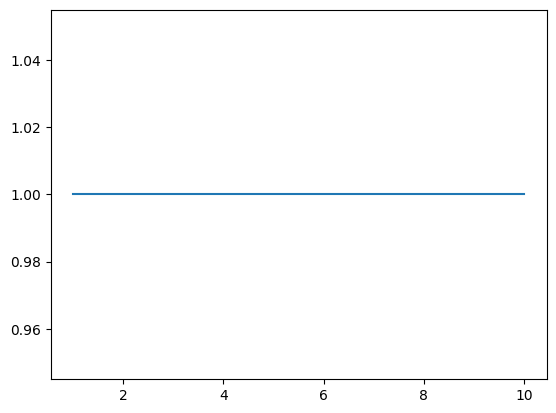

In [ ]:
#Not used
from ipywidgets import interact, IntSlider
import matplotlib.pyplot as plt
import numpy as np
import math as m
@interact
def concentration(n=IntSlider(10,10,100)):
    import matplotlib.pyplot as plt
    X = np.random.randint(0,2,size=(n))
    print(X)
    pn = np.mean(X,axis=0)
    p=0.4
    alpha = 0.05
    count = 0
    Y=[]
    for i in range(1,n+1):
      eps = ((0.5/i)*m.log(2/alpha))**0.5
      if p>=pn-eps and p<=pn+eps:
        count+=1
        Y.append(count/i)
    Xplot = np.arange(1,n+1)
    plt.plot(Xplot,Y)
    print(Xplot,Y)




In [ ]:
from ipywidgets import interact, IntSlider
import matplotlib.pyplot as plt
import numpy as np
import math as m

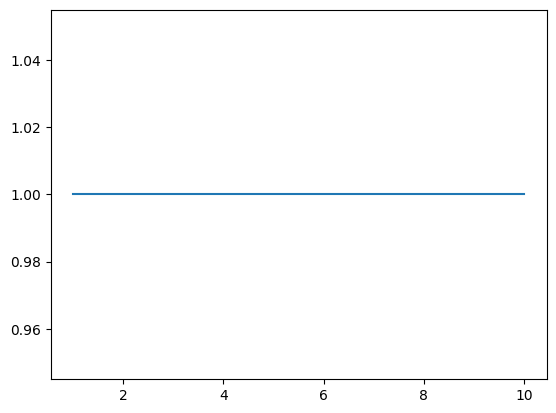

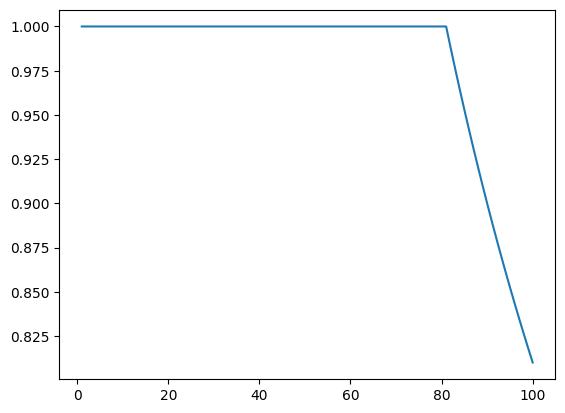

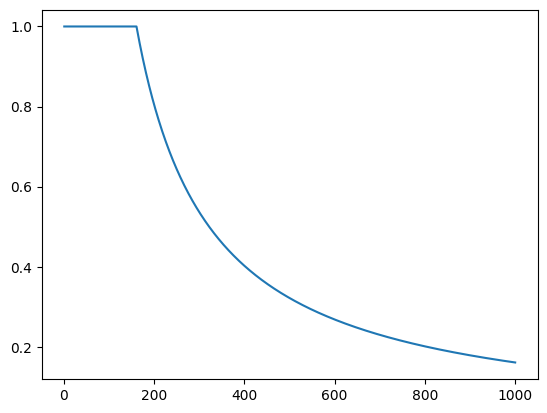

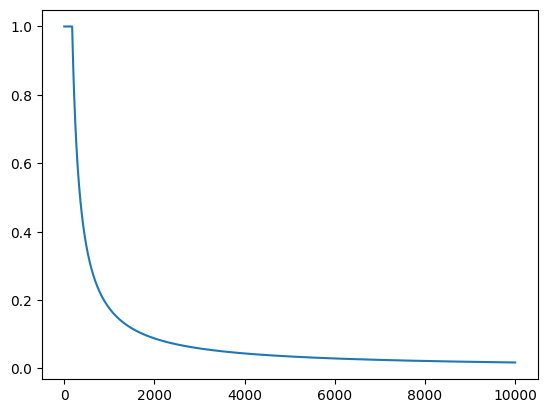

In [ ]:
n = [10,100,1000,10000]
p=0.4
alpha = 0.05

for i in n:
  X = np.random.randint(0,2,size=(i))
  pn = np.mean(X)
  Y=[]
  count=0
  for j in range(1,i+1):
      eps = ((0.5/j)*m.log(2/alpha))**0.5
      if p>=pn-eps and p<=pn+eps:
        count+=1
      Y.append(count/j)
  Xplot = np.arange(1,i+1)
  plt.plot(Xplot,Y)
  plt.show()


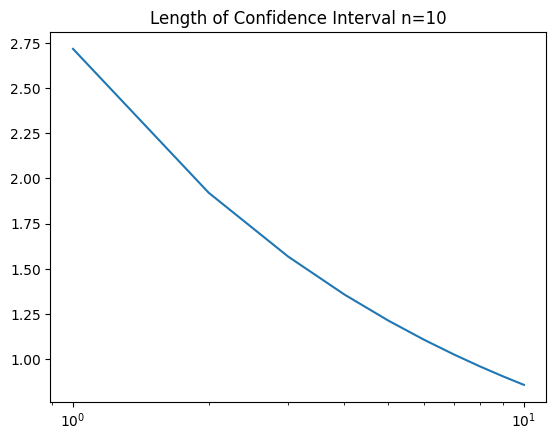

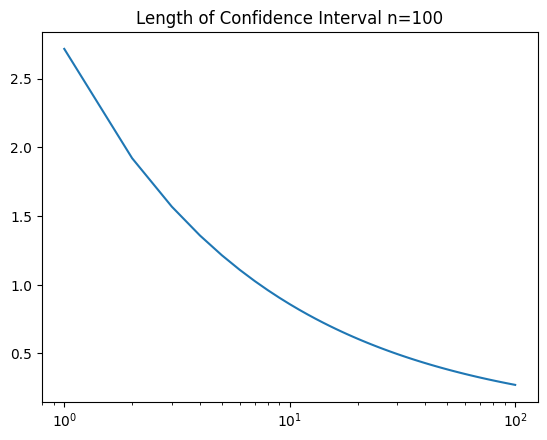

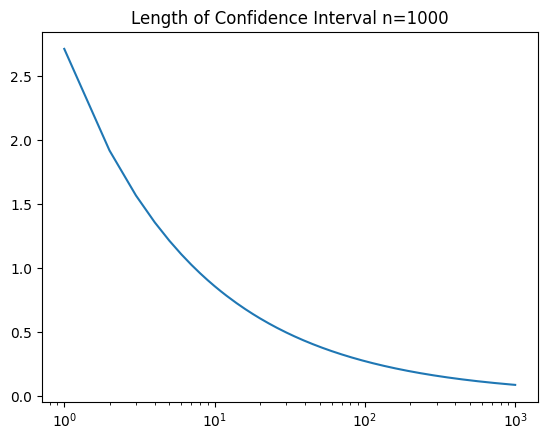

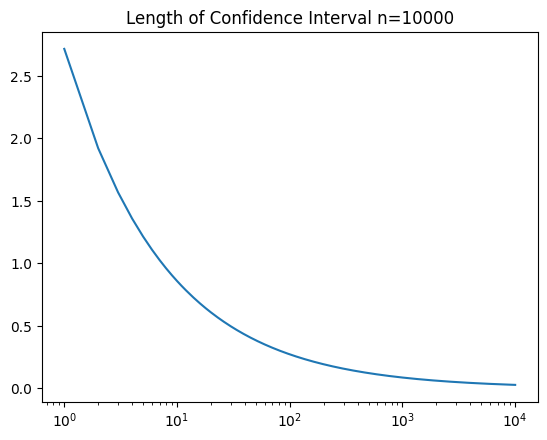

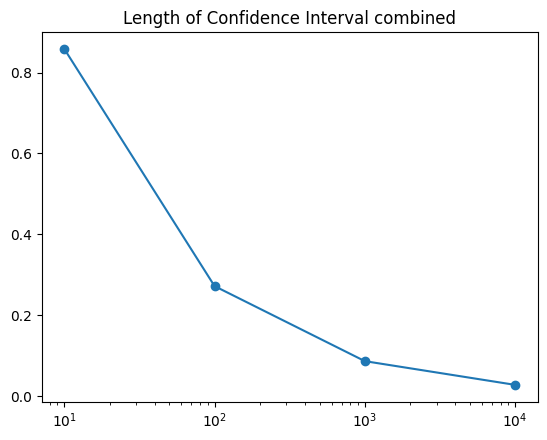

In [ ]:
alpha=0.05
n = [10,100,1000,10000]


for i in n:
  Y1=[]
  for j in range(1,i+1):
    eps = ((0.5/j)*m.log(2/alpha))**0.5
    len = 2*eps
    Y1.append(len)
  X = np.arange(1,i+1)
  plt.plot(X,Y1)
  plt.title('Length of Confidence Interval n='+str(i))
  plt.xscale('log')
  plt.show()


Y2=[]
for i in n:
  eps = ((0.5/i)*m.log(2/alpha))**0.5
  len = 2*eps
  Y2.append(len)
plt.plot(n,Y2,marker='o')
plt.xscale('log')
plt.title('Length of Confidence Interval combined')
plt.show()

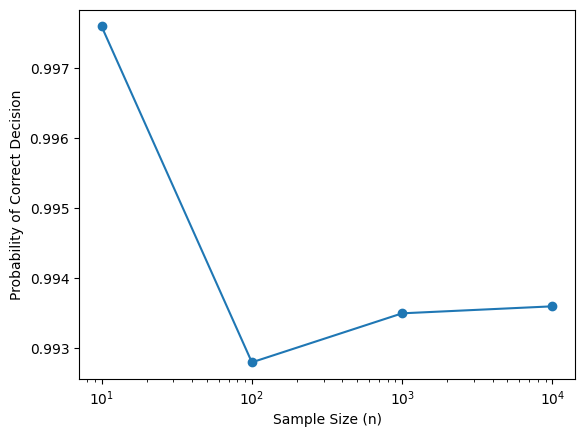

In [ ]:
p = 0.5
p_assumed = 0.4
alpha = 0.05
n_values = [10, 100, 1000, 10000]
num_simulations = 10000


def epsilon_n(n, alpha):
    return np.sqrt(1 / (2 * n) * np.log(2 / alpha))

def simulate_coverage(n, p_true, p_assumed, alpha, num_simulations):
    epsilon = epsilon_n(n, alpha)
    correct_decision_count = 0

    for _ in range(num_simulations):

        X = np.random.binomial(1, p_true, n)
        p_hat = np.mean(X)


        lower_bound = p_hat - epsilon
        upper_bound = p_hat + epsilon


        if lower_bound <= p_true <= upper_bound:
            correct_decision_count += 1


    return correct_decision_count / num_simulations


coverage_probabilities = []
for n in n_values:
    coverage_prob = simulate_coverage(n, p, p_assumed, alpha, num_simulations)
    coverage_probabilities.append(coverage_prob)

plt.plot(n_values, coverage_probabilities, marker='o')
plt.xscale('log')
plt.xlabel('Sample Size (n)')
plt.ylabel('Probability of Correct Decision')
# plt.title('Probability of Correct Decision vs Sample Size')
# plt.grid(True)
plt.show()


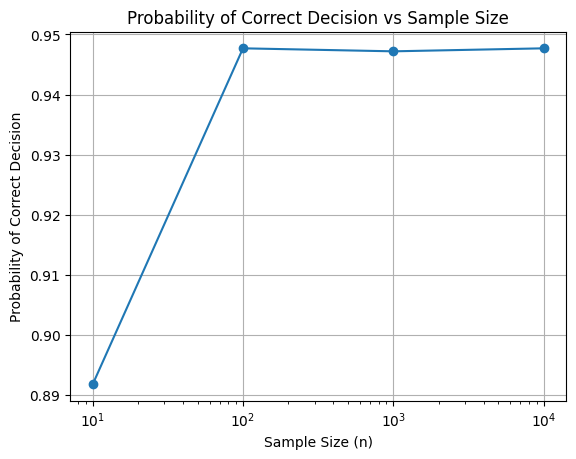

In [ ]:
import numpy as np
import scipy.stats as stats

p = 0.5
p_assumed = 0.4
alpha = 0.05
n_values = [10, 100, 1000, 10000]
num_simulations = 10000


coverage_probabilities = []
for n in n_values:
    correct_decision_count = 0

    for _ in range(num_simulations):

        X = np.random.binomial(1, p, n)
        Pn = np.mean(X)
        z = 1.96 # 95% CI
        se = z*np.sqrt(Pn * (1 - Pn) / n)

        lower_bound = Pn - se
        upper_bound = Pn + se

        if lower_bound <= p <= upper_bound:
            correct_decision_count += 1


    coverage_prob = correct_decision_count / num_simulations
    coverage_probabilities.append(coverage_prob)

plt.plot(n_values, coverage_probabilities, marker='o')
plt.xscale('log')
plt.xlabel('Sample Size (n)')
plt.ylabel('Probability of Correct Decision')
plt.title('Probability of Correct Decision vs Sample Size')
plt.grid(True)
plt.show()
